## Import libraries

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

## Load image

(<matplotlib.axes._subplots.AxesSubplot at 0x21522a03670>,
 <matplotlib.image.AxesImage at 0x21522d9c1c0>)

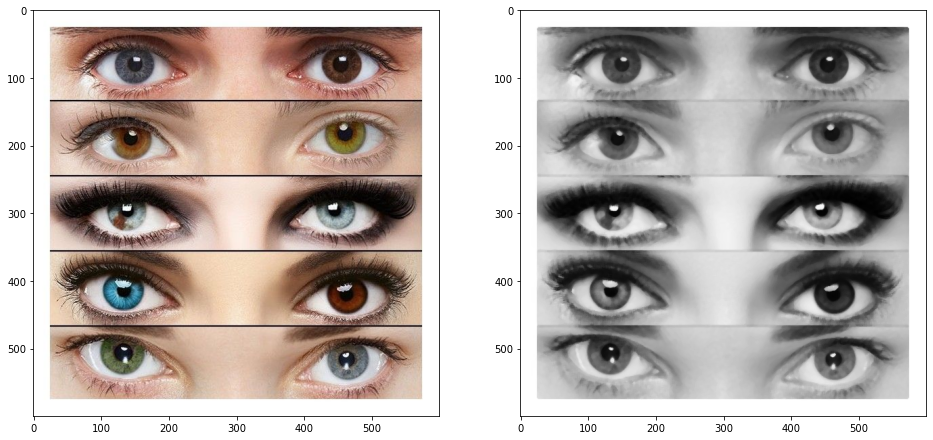

In [2]:
img_original = cv2.imread('./images/eyes.jpg')

gray = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)
gray = cv2.medianBlur(gray,5)

fig, axs = plt.subplots(1, 3,figsize=(16,8))
plt.subplot(1,2,1), plt.imshow(cv2.cvtColor(img_original,cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2), plt.imshow(gray,cmap = 'gray')

## Find eye iris

In [3]:
def get_distance(circles):
    """circles = [[x1,y1,radius1],[x2,y2,radius2]]
    return euclidean distance between (x1,y1) (x2,y2)
    """
    circles = np.double(circles)
    c1 = circles[0]
    c2 = circles[1]
    return np.sqrt((c1[0]-c2[0])**2+(c1[1]-c2[1])**2)

def pairwise(iterable):
    "s -> (s0, s1), (s2, s3), (s4, s5), ..."
    a = iter(iterable)
    return zip(a, a)


Distance 0 = 306
Distance 1 = 316
Distance 2 = 310
Distance 3 = 332
Distance 4 = 332


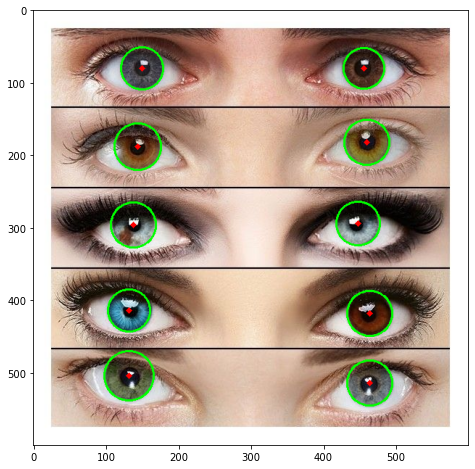

In [4]:
img_out = img_original.copy()
img_out = cv2.cvtColor(img_out,cv2.COLOR_BGR2RGB)

# HoughCircles parameters
dp = 1                        # Inverse ratio of the accumulator resolution to the image resolution
min_dist = 50                 # Minimum distance between the centers of the detected circles
canny_max_threshold = 250     # Higher threshold of the two passed to the Canny edge detector and the lower one is twice smaller (for HOUGH_GRADIENT)
threshold = 20                # Accumulator threshold for the circle centers at the detection stage (for HOUGH_GRADIENT)
min_rad = 20                  # Minimum circle radius
max_radius = 50               # Maximum circle radius

# Get circles
circles = cv2.HoughCircles(gray,cv2.HOUGH_GRADIENT,dp,minDist=min_dist,
                              param1=canny_max_threshold,param2=threshold,minRadius=min_rad,maxRadius=max_radius)
circles =  np.squeeze(np.uint16(np.around(circles)))

# Draw circles (also works)
# for c in circles: # c = [x,y,radius]     
#      cv2.circle(img_out,(c[0],c[1]),c[2],(0,255,0),2) # Draw the outer circle   
#      cv2.circle(img_out,(c[0],c[1]),2,(0,0,255),3) # Draw the center of the circle

# Sort circles by "y" center coordinate
circles = circles[circles[:, 1].argsort()]

# Group circles by pair of eyes
iris_pair = []
for eye1, eye2 in pairwise(circles):
    iris_pair.append((eye1,eye2))
iris_pair = np.array(iris_pair)

# Plot circles and get distance between centers
iris_distance = []
for i,iris in enumerate(iris_pair):   # iris = [[x1,y1,radius1],[x2,y2,radius2]]
     for eye in iris:                 # eye = [x,y,radius]
          cv2.circle(img_out,(eye[0],eye[1]),eye[2],(0,255,0),2) # Draw the outer circle   
          cv2.circle(img_out,(eye[0],eye[1]),2,(255,0,0),3)      # Draw the center of the circle
     iris_distance.append(get_distance(iris))
     print("Distance "+str(i)+" = "+str(int(iris_distance[-1])))

fig = plt.figure(figsize=(16,8)), plt.imshow(img_out)

## Find eye pupil

Min iris radius = 28 => Max pupil radius = 50% * min_iris_radius = 14


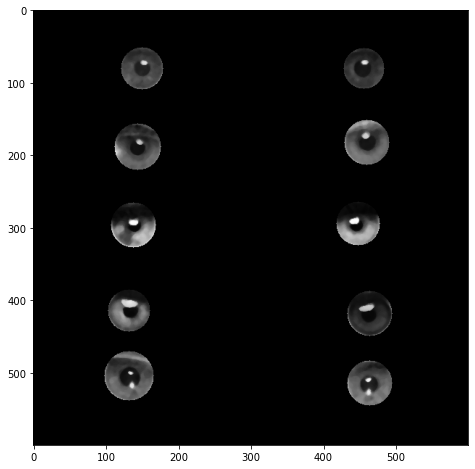

In [5]:
# Create mask to search in ROI and get min pupil radius
mask = np.zeros(img_original.shape[:2])
min_iris_radius = np.max(img_original.shape[:2])
for i,iris in enumerate(iris_pair):   # iris = [[x1,y1,radius1],[x2,y2,radius2]]
     for eye in iris:                 # eye = [x,y,radius]
          mask = cv2.circle(mask,(eye[0],eye[1]),eye[2],1,-1)
          if(eye[2]<min_iris_radius):
               min_iris_radius=eye[2]

max_pupil_radius = np.int(np.ceil(.5*min_iris_radius))
gray_blur = cv2.medianBlur(gray,3)
masked_eyes =  np.uint8(mask*gray_blur)

print("Min iris radius = "+str(min_iris_radius)+" => Max pupil radius = 50% * min_iris_radius = "+str(max_pupil_radius))
fig = plt.figure(figsize=(16,8)), plt.imshow(masked_eyes,cmap="gray")

Distance 0 = 304
Distance 1 = 316
Distance 2 = 306
Distance 3 = 326
Distance 4 = 332


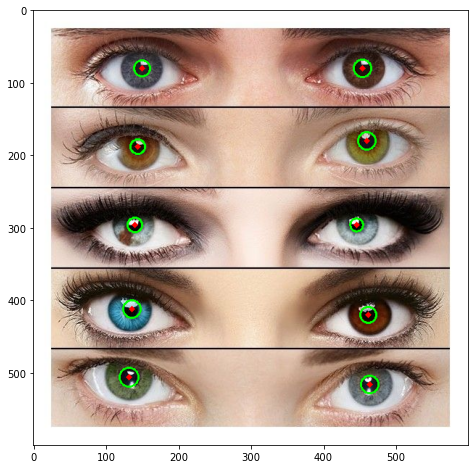

In [6]:
img_out = img_original.copy()
img_out = cv2.cvtColor(img_out,cv2.COLOR_BGR2RGB)

# img_out = np.dstack([masked_eyes,masked_eyes,masked_eyes]) # For test

# HoughCircles parameters
dp = 1                          # Inverse ratio of the accumulator resolution to the image resolution
min_dist = 60                   # Minimum distance between the centers of the detected circles
canny_max_threshold = 120       # Higher threshold of the two passed to the Canny edge detector and the lower one is twice smaller (for HOUGH_GRADIENT)
threshold = 15                  # Accumulator threshold for the circle centers at the detection stage (for HOUGH_GRADIENT)
min_rad = 3                     # Minimum circle radius
max_radius = 14   # Maximum circle radius

# Get circles
circles = cv2.HoughCircles(masked_eyes,cv2.HOUGH_GRADIENT,dp,minDist=min_dist,
                              param1=canny_max_threshold,param2=threshold,minRadius=min_rad,maxRadius=max_radius)
circles =  np.squeeze(np.uint16(np.around(circles)))

# Draw circles (also works)
# for c in circles: # c = [x,y,radius]
#      cv2.circle(img_out,(c[0],c[1]),c[2],(0,255,0),2) # Draw the outer circle   
#      cv2.circle(img_out,(c[0],c[1]),2,(0,0,255),3) # Draw the center of the circle

# Sort circles by "y" center coordinate
circles = circles[circles[:, 1].argsort()]

# Group circles by pair of eyes
pupil_pair = []
for eye1, eye2 in pairwise(circles):
    pupil_pair.append((eye1,eye2))
pupil_pair = np.array(pupil_pair)

# Plot circles and get distance between centers
pupil_distance = []
for i,pupil in enumerate(pupil_pair):   # pupil = [[x1,y1,radius1],[x2,y2,radius2]]
     for eye in pupil:                 # eye = [x,y,radius]
          cv2.circle(img_out,(eye[0],eye[1]),eye[2],(0,255,0),2) # Draw the outer circle   
          cv2.circle(img_out,(eye[0],eye[1]),2,(255,0,0),3)      # Draw the center of the circle
     pupil_distance.append(get_distance(pupil))
     print("Distance "+str(i)+" = "+str(int(pupil_distance[-1])))
     
fig = plt.figure(figsize=(16,8)), plt.imshow(img_out)